<h1 style="color: blue; font-style: italic; font-family: sans-serif; text-align: center;">Revolutionizing Recommendations as a Personalization Strategy:<p style="color:brown; text-align: center;">Traditional Approaches</p><p style="color:brown; text-align: center;">Association Rule Mining (ARM)</p></h1>

### [Article: Revolutionizing Recommendations as a Personalization Strategy: Traditional Approach](https://medium.com/@shukla.shankar.ravi/revolutionizing-recommendations-as-a-personalization-strategy-traditional-approach-5de4d3b9aadc)

# Association Rule Mining (ARM) Recommendation

In [1]:
import pandas as pd
import random

from mlxtend.frequent_patterns import apriori, fpgrowth
from mlxtend.frequent_patterns import association_rules
from mlxtend.preprocessing import TransactionEncoder

import networkx as nx
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import matplotlib.colors as mcolors

import warnings
warnings.filterwarnings("ignore")
random.seed(9973)


## Step 1: Load the data

In [2]:
fields = ['order_id', 'product_description']
df = pd.read_csv('./data/order_items_description.csv', encoding='unicode_escape', usecols=fields).drop_duplicates()
print(f"Dataset Info:\n\n {df.info()}")

<class 'pandas.core.frame.DataFrame'>
Index: 409572 entries, 0 to 524502
Data columns (total 2 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   order_id             409572 non-null  int64 
 1   product_description  409572 non-null  object
dtypes: int64(1), object(1)
memory usage: 9.4+ MB
Dataset Info:

 None


In [3]:
print(f"Raw Dataset:\n\n {df}")

Raw Dataset:

         order_id product_description
0              1            Potatoes
1              1                Milk
2              1          Red Grapes
3              1         Gala Apples
4              1     Russet Potatoes
...          ...                 ...
524498     50000             Oranges
524499     50000              Laptop
524500     50000         Fuji Apples
524501     50000                Kiwi
524502     50000            Desktops

[409572 rows x 2 columns]


## Step 2: Create a list of transactions by grouping by InvoiceNo

In [4]:
dataset = df.groupby('order_id')['product_description'].apply(list).tolist()

# association_rule_mining_dataset.csv will be used in Vector Embedding based recommendation modeling
pd.DataFrame(dataset).to_csv("./data/association_rule_mining_dataset.csv", index=False)

## Step 3: Convert dataset to a DataFrame using TransactionEncoder

In [5]:
# Initialize the transaction encoder
te = TransactionEncoder()

# Fit the encoder to the dataset and transform the transaction list
# - dataset: list of transactions, where each transaction is a list of items (e.g., [['milk', 'bread'], ['bread', 'eggs']])
# - .fit(dataset): learns the unique items in all transactions
# - .transform(dataset): converts each transaction into a one-hot encoded boolean array
te_ary = te.fit(dataset).transform(dataset)

# Convert the encoded array into a pandas DataFrame for analysis
# - Each column represents a unique item
# - Each row represents a transaction
# - True means the item is present in that transaction; False otherwise
df = pd.DataFrame(te_ary, columns=te.columns_)

print(f"TransactionEncoder dataset:\n\n")
print(df.head())

TransactionEncoder dataset:


   Avocado  Bananas  Black beans  Blueberries  Desktops   Eggs  Fuji Apples  \
0    False    False        False        False     False  False        False   
1     True    False         True        False     False   True        False   
2    False    False        False        False      True  False         True   
3     True    False         True        False      True   True         True   
4    False    False        False        False     False   True         True   

   Gala Apples  Green Grapes   Kiwi  Laptop  Lentils   Milk  Oranges  \
0         True         False  False   False    False   True    False   
1         True         False  False    True     True   True    False   
2        False         False  False    True    False   True    False   
3        False          True   True   False     True   True     True   
4         True         False  False    True     True  False     True   

   Potatoes  Red Grapes  Red Potatoes  Russet Potatoes  Strawb

## Step 4: Use the Apriori algorithm for frequent itemset mining

In [6]:
# Apply the Apriori algorithm to the encoded transaction DataFrame
# - df: a boolean DataFrame where each column is an item and each row is a transaction (from TransactionEncoder)
# - min_support=0.01: include only those itemsets that appear in at least 1% of the transactions
# - use_colnames=True: return actual item names instead of column indices
frequent_itemsets_apriori = apriori(df, min_support=0.01, use_colnames=True)


print(f"Frequent itemsets using Apriori:\n\n {frequent_itemsets_apriori.head()}")

Frequent itemsets using Apriori:

    support       itemsets
0  0.41004      (Avocado)
1  0.41058      (Bananas)
2  0.40898  (Black beans)
3  0.40798  (Blueberries)
4  0.40800     (Desktops)


## Step 5: Generate association rules from frequent itemsets (using Apriori)

In [7]:
# Generate association rules from the frequent itemsets using the Apriori output.
# Parameters:
# - frequent_itemsets_apriori: Output from the apriori() function containing itemsets and their support.
# - metric="confidence": Use 'confidence' as the evaluation metric for rules.
# - min_threshold=0.4: Keep only those rules with confidence ≥ 0.4 (i.e., 40%).
rules_apriori = association_rules(frequent_itemsets_apriori, metric="confidence", min_threshold=0.4)

# rules_apriori_dataset.csv will be used in BERT based recommendation modeling
rules_apriori.to_csv("./data/rules_apriori_dataset.csv", index=False)

print(f"Association rules from Apriori itemsets:\n\n")
print(rules_apriori[["antecedents", "consequents", "confidence"]].head(5))

Association rules from Apriori itemsets:


     antecedents    consequents  confidence
0      (Bananas)      (Avocado)    0.408544
1      (Avocado)      (Bananas)    0.409082
2  (Black beans)      (Avocado)    0.405986
3      (Avocado)  (Black beans)    0.404936
4  (Blueberries)      (Avocado)    0.404628


## Step 6: Create a network graph to visualize the characteristics of the association rules

In [8]:
def rule_graph(filter_item):
    print(f"Rule Graph {filter_item}")
    
    # Filter rules where the antecedent has the same length as the filter_item
    rules_apriori_item = rules_apriori[rules_apriori['antecedents'].apply(lambda x: len(x) == len(filter_item))]
    
    # Sort the filtered rules by descending confidence
    rules_apriori_item_sorted = rules_apriori_item.sort_values(by='confidence', ascending=False)
    
    # Further filter rules where the filter_item is a subset of the antecedent
    rules_apriori_item_filtered = rules_apriori_item_sorted[
        rules_apriori_item_sorted['antecedents'].apply(lambda x: set(filter_item).issubset(x))]

    # Create a network graph to visualize the characteristics of the association rules

    # Create a graph - Initialize a new undirected graph
    G = nx.Graph()

    # Add nodes and edges for each filtered rule
    for _, row in rules_apriori_item_filtered.iterrows():
        # Convert frozenset to string
        antecedents_str = ', '.join(list(row['antecedents']))
        consequents_str = ', '.join(list(row['consequents']))

        # Add nodes and an edge between antecedent and consequent, weighted by confidenc
        G.add_node(antecedents_str)
        G.add_node(consequents_str)
        G.add_edge(antecedents_str, consequents_str, weight=row['confidence'])


    # Prepare color map for visualizing edge weights (confidence values)
    colormap = get_cmap('viridis')
    metrics_values = [data["weight"] for _, _, data in G.edges(data=True)]
    metrics_min = min(metrics_values)
    metrics_max = max(metrics_values)
    metrics_norm = mcolors.Normalize(vmin=metrics_min, vmax=metrics_max)

    # Define edge colors and widths based on confidence values
    edge_colors = metrics_values
    edge_widths = 3

    # Plot the graph
    fig, ax = plt.subplots(figsize=(7, 4))
    pos = nx.spring_layout(G, k=0.15, iterations=20)
    
    # Draw nodes and labels
    nx.draw_networkx_nodes(G, pos, node_color="azure", node_size=50)
    nx.draw_networkx_labels(G, pos, font_size=8)
    
    # Draw edges with confidence-based color and width
    nx.draw(G, pos, edge_color=edge_colors, width=edge_widths, edge_cmap=colormap, edge_vmin=metrics_min, edge_vmax=metrics_max)
    
    # Add color bar to indicate confidence scale
    cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=colormap, norm=metrics_norm), ax=ax, shrink=0.4)
    cbar.set_label("Confidence Value")

    plt.axis("off")
    plt.show()
    

## Step 7: Display Associated Rules

Rule Graph ['Avocado']


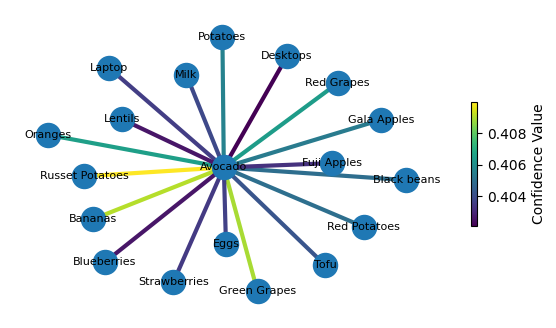

Rule Graph ['Avocado', 'Russet Potatoes']


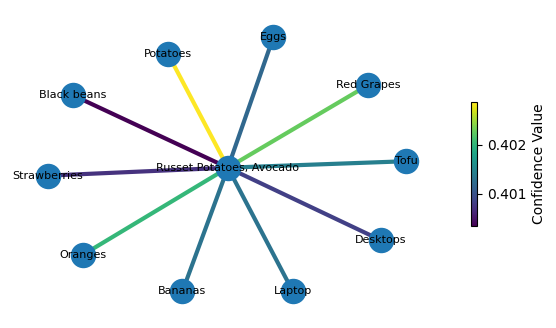

Rule Graph ['Avocado', 'Russet Potatoes', 'Potatoes']


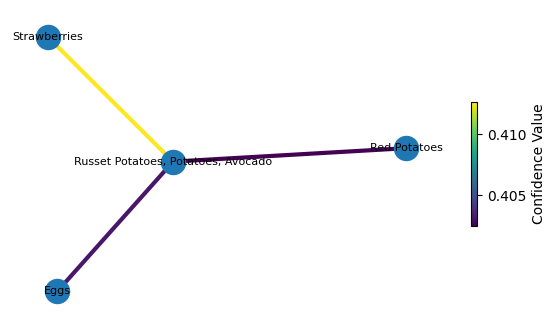

Rule Graph ['Avocado', 'Russet Potatoes', 'Potatoes', 'Eggs']


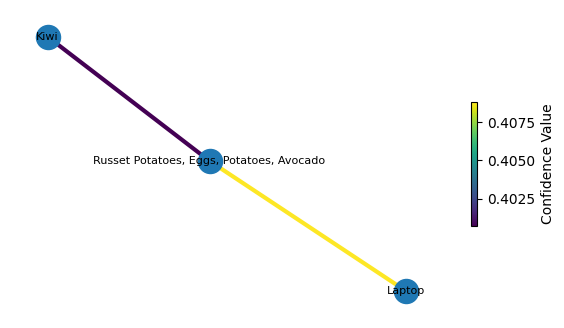

In [9]:
rule_graph(["Avocado"])
rule_graph(["Avocado", "Russet Potatoes"])
rule_graph(["Avocado", "Russet Potatoes","Potatoes"])
rule_graph(["Avocado", "Russet Potatoes","Potatoes", "Eggs"])